# BBBP Dataset Analysis and Machine Learning Pipeline

This notebook performs a complete analysis of the Blood-Brain Barrier Penetration (BBBP) dataset, including:
- Data download and parsing
- Molecular structure analysis
- Fingerprint generation
- Machine learning model training
- Model evaluation and visualization


In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem import MolToInchi, MolToInchiKey, Draw, rdFingerprintGenerator
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
import xgboost as xgb
from sklearn.metrics import accuracy_score
from IPython.display import display, Image

print("All libraries imported successfully!")


All libraries imported successfully!


## Step 1: Download BBBP Dataset


In [2]:
def download_bbbp_dataset():
    """
    Downloads the BBBP (Blood-Brain Barrier Penetration) dataset from DeepChem
    and returns it as a Pandas DataFrame.
    
    Returns:
        pd.DataFrame: The BBBP dataset with columns: num, name, p_np, smiles
    """
    url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv"
    df = pd.read_csv(url)
    return df

# Download the dataset
print("Downloading BBBP dataset...")
df = download_bbbp_dataset()
print(f"Dataset downloaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()


Dataset downloaded successfully!
Shape: (2050, 4)
Columns: ['num', 'name', 'p_np', 'smiles']

First few rows:


num                  name  p_np  \
0    1            Propanolol     1   
1    2  Terbutylchlorambucil     1   
2    3                 40730     1   
3    4                    24     1   
4    5           cloxacillin     1   

                                              smiles  
0                   [Cl].CC(C)NCC(O)COc1cccc2ccccc12  
1           C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl  
2  c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...  
3                   C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C  
4  Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...

## Step 2: Parse Molecules with RDKit and Add Identifiers


In [3]:
def parse_molecules_with_rdkit(df):
    """
    Parses SMILES strings using RDKit and adds mol, inchi, inchikey, and id columns.
    Separates successfully parsed molecules from those that cannot be parsed.
    
    Args:
        df (pd.DataFrame): DataFrame with a 'smiles' column
        
    Returns:
        tuple: (parsed_df, failed_df) where:
            - parsed_df: DataFrame with successfully parsed molecules including 
                        mol, inchi, inchikey, and id columns
            - failed_df: DataFrame with molecules that could not be parsed
    """
    parsed_rows = []
    failed_rows = []
    
    for idx, row in df.iterrows():
        smiles = row['smiles']
        try:
            # Parse SMILES string
            mol = Chem.MolFromSmiles(smiles)
            
            if mol is None:
                # Failed to parse
                failed_rows.append(row)
            else:
                # Successfully parsed - add mol, inchi, inchikey, and id
                row_dict = row.to_dict()
                row_dict['mol'] = mol
                row_dict['inchi'] = MolToInchi(mol)
                inchikey = MolToInchiKey(mol)
                row_dict['inchikey'] = inchikey
                row_dict['id'] = inchikey.split('-')[0]  # First part of inchikey
                parsed_rows.append(row_dict)
        except Exception as e:
            # Exception during parsing
            failed_rows.append(row)
    
    # Create dataframes
    parsed_df = pd.DataFrame(parsed_rows)
    failed_df = pd.DataFrame(failed_rows)
    
    return parsed_df, failed_df

# Parse molecules
print("Parsing molecules with RDKit...")
parsed_df, failed_df = parse_molecules_with_rdkit(df)

print(f"\nSuccessfully parsed: {len(parsed_df)} molecules")
print(f"Failed to parse: {len(failed_df)} molecules")
print(f"\nParsed dataframe columns: {parsed_df.columns.tolist()}")
print(f"\nFirst few parsed molecules:")
# Display without the mol column (which is an object)
display_cols = [col for col in parsed_df.columns if col != 'mol']
parsed_df[display_cols].head()


Parsing molecules with RDKit...


[16:24:51] WARNING: Omitted undefined stereo

[16:24:51] WARNING: Omitted undefined stereo

[16:24:51] WARNING: Omitted undefined stereo

[16:24:51] WARNING: Omitted undefined stereo

[16:24:51] WARNING: Omitted undefined stereo

[16:24:51] WARNING: Omitted undefined stereo

[16:24:51] WARNING: Omitted undefined stereo

[16:24:51] WARNING: Omitted undefined stereo

[16:24:51] WARNING: Omitted undefined stereo

[16:24:51] WARNING: Charges were rearranged; Omitted undefined stereo

[16:24:51] WARNING: Omitted undefined stereo

[16:24:51] WARNING: Charges were rearranged

[16:24:51] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:24:51] WARNING: not removing hydrogen atom without neighbors
[16:24:51] WARNING: Proton(s) added/removed

[16:24:51] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:24:51] WARNING: Omitted undefined stereo

[16:24:51] WARNING: Omitted undefined stereo

[16:24:51] WARNING: Charges were rearranged; Omitted undefined stereo

[16:2


Successfully parsed: 2039 molecules
Failed to parse: 11 molecules

Parsed dataframe columns: ['num', 'name', 'p_np', 'smiles', 'mol', 'inchi', 'inchikey', 'id']

First few parsed molecules:


[16:24:53] WARNING: Omitted undefined stereo

[16:24:53] WARNING: Omitted undefined stereo

[16:24:53] WARNING: Omitted undefined stereo

[16:24:53] WARNING: Omitted undefined stereo

[16:24:53] WARNING: Omitted undefined stereo

[16:24:53] WARNING: Omitted undefined stereo

[16:24:53] WARNING: Omitted undefined stereo

[16:24:53] WARNING: Proton(s) added/removed

[16:24:53] WARNING: Omitted undefined stereo

[16:24:53] WARNING: Omitted undefined stereo

[16:24:53] WARNING: Omitted undefined stereo

[16:24:53] WARNING: Omitted undefined stereo

[16:24:53] WARNING: Omitted undefined stereo

[16:24:53] WARNING: Omitted undefined stereo

[16:24:53] WARNING: Omitted undefined stereo

[16:24:53] WARNING: not removing hydrogen atom without neighbors
[16:24:53] WARNING: Proton(s) added/removed

[16:24:53] WARNING: Omitted undefined stereo

[16:24:53] WARNING: Omitted undefined stereo

[16:24:53] WARNING: Omitted undefined stereo

[16:24:53] WARNING: Omitted undefined stereo

[16:24:53] WARNIN

num                  name  p_np  \
0    1            Propanolol     1   
1    2  Terbutylchlorambucil     1   
2    3                 40730     1   
3    4                    24     1   
4    5           cloxacillin     1   

                                              smiles  \
0                   [Cl].CC(C)NCC(O)COc1cccc2ccccc12   
1           C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl   
2  c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...   
3                   C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C   
4  Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...   

                                               inchi  \
0  InChI=1S/C16H21NO2.Cl/c1-12(2)17-10-14(18)11-1...   
1  InChI=1S/C18H27Cl2NO2/c1-18(2,3)23-17(22)6-4-5...   
2  InChI=1S/C18H20FN3O4/c1-10-9-26-17-14-11(16(23...   
3  InChI=1S/C17H26N2O2/c1-15(20)18-9-6-12-21-17-8...   
4  InChI=1S/C19H18ClN3O5S/c1-8-11(12(22-28-8)9-6-...   

                      inchikey              id  
0  AOLIYNUVSUQXCB-UHFFFAOYSA-N  AOLIYNUVSUQXCB  
1  SZXDOYFHSIIZCF-UHFFFAOYSA-N  SZXDOYFHSIIZCF  
2  GSDSWSVVBLHKDQ-UHFFFAOYSA-N  GSDSWSVVBLHKDQ  
3  FAXLXLJWHQJMPK-UHFFFAOYSA-N  FAXLXLJWHQJMPK  
4  LQOLIRLGBULYKD-JKIFEVAISA-N  LQOLIRLGBULYKD

## Step 3: List Molecules That Failed to Parse


In [4]:
def list_failed_molecules(failed_df):
    """
    Lists all molecules that failed to parse with RDKit.
    
    Args:
        failed_df (pd.DataFrame): DataFrame with molecules that failed to parse
    """
    if len(failed_df) == 0:
        print("No failed molecules to list.")
        return
    
    print(f"\nAll {len(failed_df)} molecules that failed to parse:")
    print("=" * 80)
    
    for idx, (_, row) in enumerate(failed_df.iterrows(), 1):
        num = row.get('num', '')
        name = row.get('name', f'Molecule {idx}')
        smiles = row.get('smiles', 'N/A')
        p_np = row.get('p_np', '')
        
        print(f"\n{idx}. Number: {num}")
        print(f"   Name: {name}")
        print(f"   SMILES: {smiles}")
        print(f"   p_np: {p_np}")
    
    print("\n" + "=" * 80)

# List failed molecules
if len(failed_df) > 0:
    list_failed_molecules(failed_df)
else:
    print("No molecules failed to parse!")



All 11 molecules that failed to parse:

1. Number: 60
   Name: 15
   SMILES: O=N([O-])C1=C(CN=C1NCCSCc2ncccc2)Cc3ccccc3
   p_np: 1

2. Number: 62
   Name: 22767
   SMILES: c1(nc(NC(N)=[NH2])sc1)CSCCNC(=[NH]C#N)NC
   p_np: 1

3. Number: 393
   Name: ICI17148
   SMILES: Cc1nc(sc1)\[NH]=C(\N)N
   p_np: 1

4. Number: 616
   Name: 5-6
   SMILES: s1cc(CSCCN\C(NC)=[NH]\C#N)nc1\[NH]=C(\N)N
   p_np: 1

5. Number: 644
   Name: 12
   SMILES: c1c(c(ncc1)CSCCN\C(=[NH]\C#N)NCC)Br
   p_np: 0

6. Number: 647
   Name: 16
   SMILES: n1c(csc1\[NH]=C(\N)N)c1ccccc1
   p_np: 1

7. Number: 648
   Name: 17
   SMILES: n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N
   p_np: 0

8. Number: 649
   Name: 18
   SMILES: n1c(csc1\[NH]=C(\N)N)c1cccc(c1)NC(C)=O
   p_np: 0

9. Number: 650
   Name: 19
   SMILES: n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N\C(NC)=[NH]\C#N
   p_np: 0

10. Number: 651
   Name: 2
   SMILES: s1cc(nc1\[NH]=C(\N)N)C
   p_np: 1

11. Number: 687
   Name: 9-C17
   SMILES: c1(cc(N\C(=[NH]\c2cccc(c2)CC)C)ccc1)CC
   p_np: 1



## Step 4: Deduplication by ID and Show Molecules with Multiple Labels


Deduplicating molecules by 'id'...

Deduplication results:
  Total unique IDs: 1949
  Consistent labels (single-element sets): 1935
  Inconsistent labels (multiple elements): 29 molecules

Drawing 29 molecules with inconsistent labels...


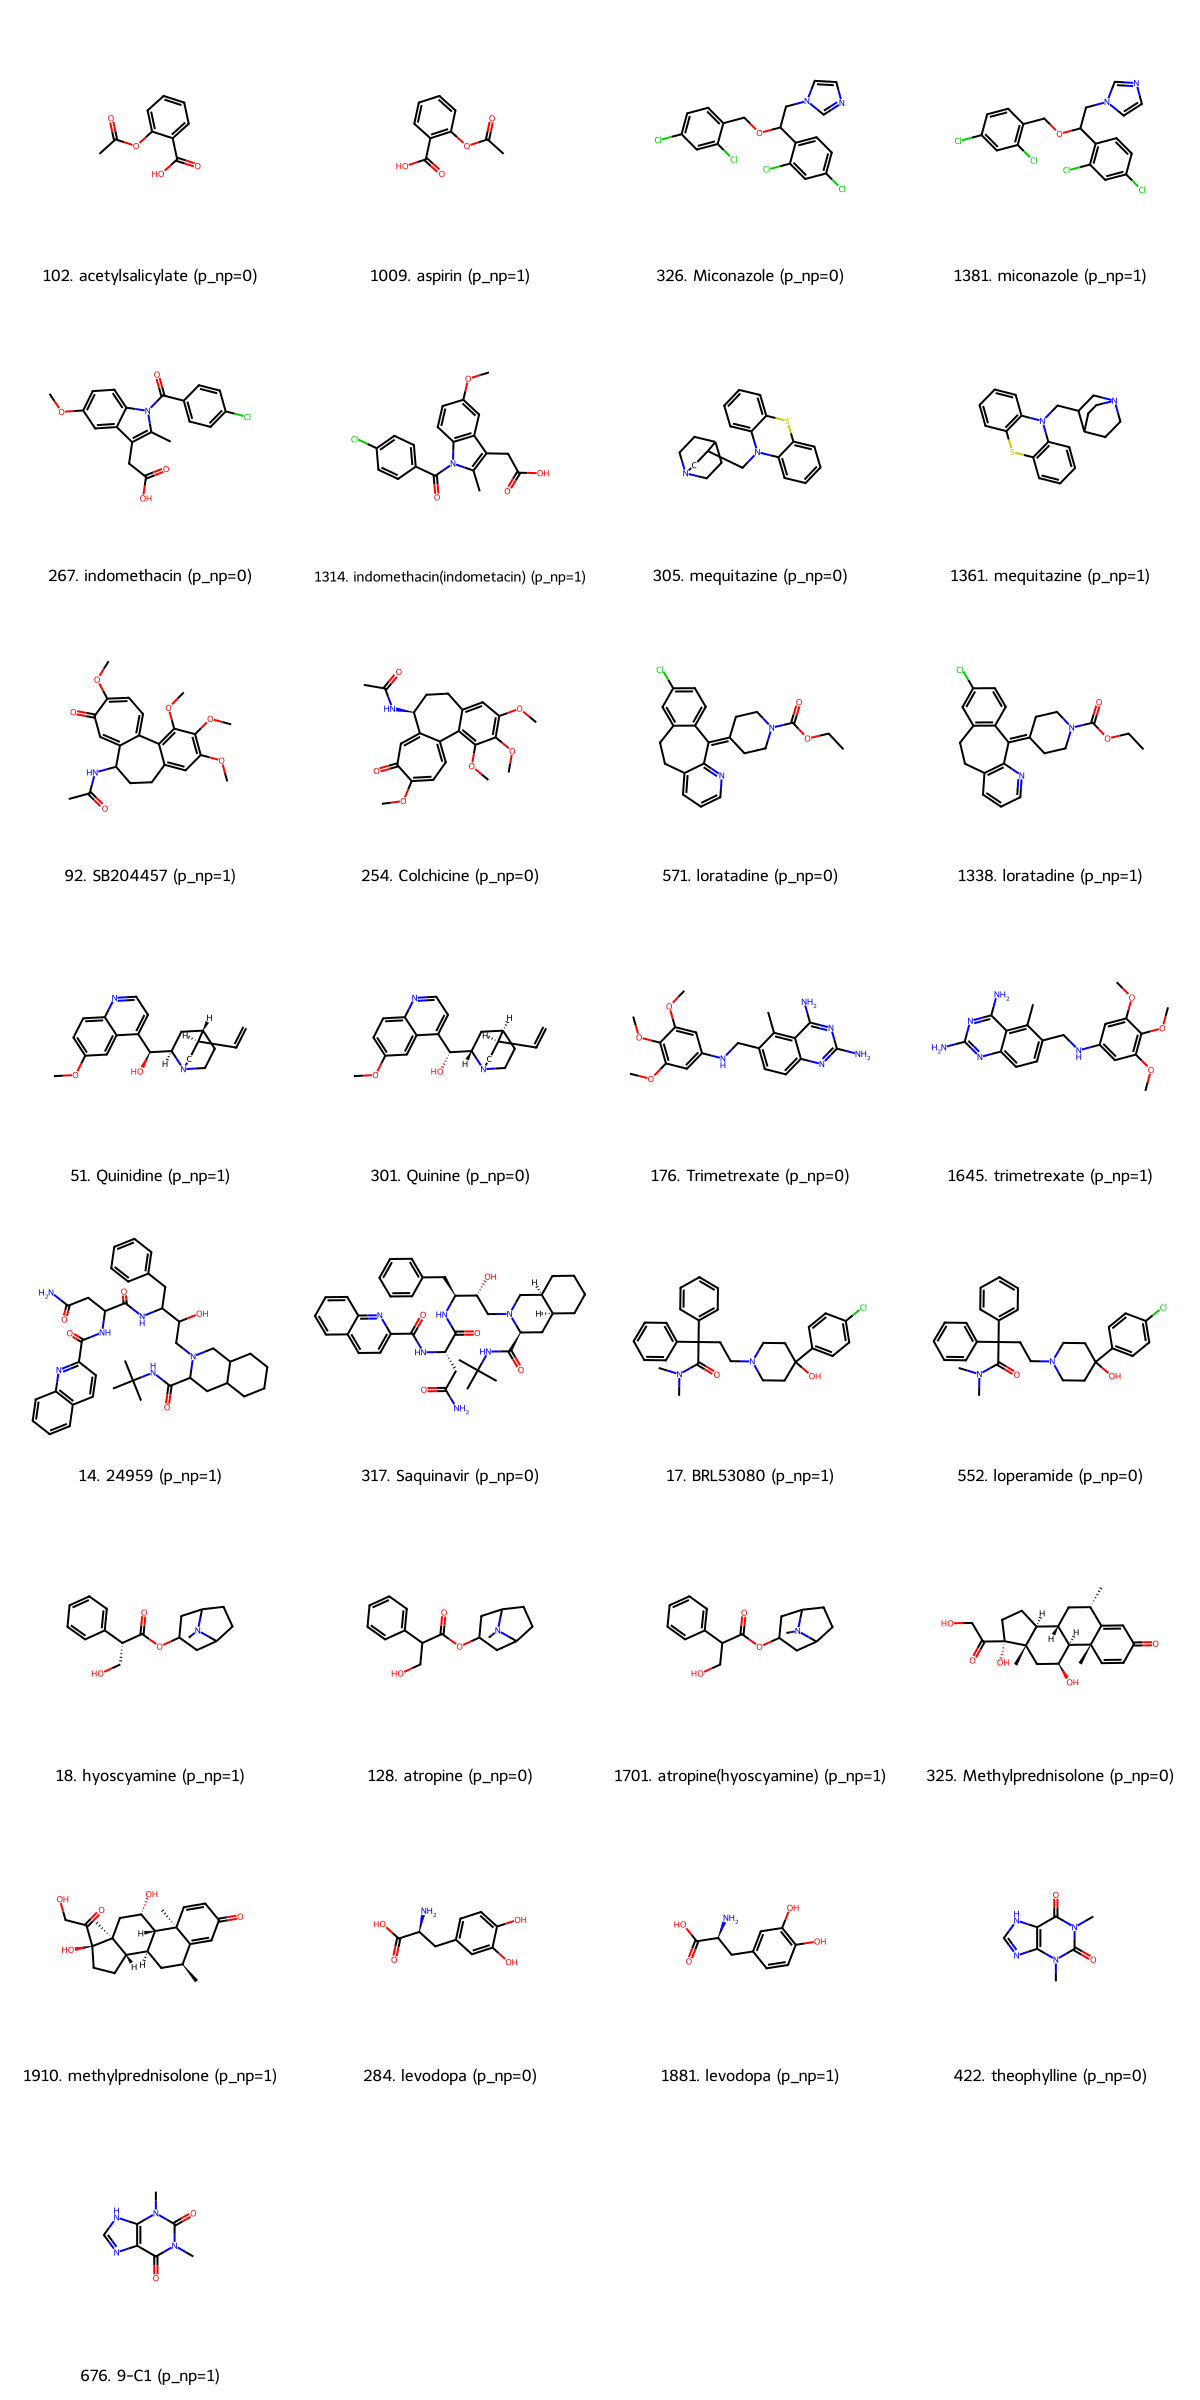


Deduplicated dataframe shape: (1935, 8)
Deduplicated dataframe columns: ['num', 'name', 'p_np', 'smiles', 'mol', 'inchi', 'inchikey', 'id']

First few deduplicated molecules:


num                 name  p_np  \
0  1302       hydromorphinol     1   
1   581             diazepam     1   
2  1245      fludrocortisone     1   
3  1653         valdipromide     1   
4   260  guanethidinesulfate     0   

                                              smiles  \
0  [C@@]125C3=C4C[C@H]([C@@]1(CC[C@@H]([C@@H]2OC3...   
1                CN1C(=O)CN=C(c2ccccc2)c3cc(Cl)ccc13   
2  [C@H]23[C@@]([C@@]1(C(=CC(=O)CC1)CC2)C)([C@H](...   
3                             C(C(C(N)=O)(CCC)CCC)CC   
4                                NC(N)=NCCN1CCCCCCC1   

                                               inchi  \
0  InChI=1S/C17H21NO4/c1-18-7-6-16-13-9-2-3-10(19...   
1  InChI=1S/C16H13ClN2O/c1-19-14-8-7-12(17)9-13(1...   
2  InChI=1S/C21H29FO5/c1-18-7-5-13(24)9-12(18)3-4...   
3  InChI=1S/C11H23NO/c1-4-7-11(8-5-2,9-6-3)10(12)...   
4  InChI=1S/C10H22N4/c11-10(12)13-6-9-14-7-4-2-1-...   

                      inchikey              id  
0  AABLHGPVOULICI-BRJGLHKUSA-N  AABLHGPVOULICI  
1  AAOVKJBEBIDNHE-UHFFFAOYSA-N  AAOVKJBEBIDNHE  
2  AAXVEMMRQDVLJB-BULBTXNYSA-N  AAXVEMMRQDVLJB  
3  ACBLZFZDCOGNHD-UHFFFAOYSA-N  ACBLZFZDCOGNHD  
4  ACGDKVXYNVEAGU-UHFFFAOYSA-N  ACGDKVXYNVEAGU

In [5]:
def deduplicate_by_id(parsed_df, molsPerRow=4):
    """
    Deduplicates molecules by 'id' column. For each unique 'id', collects 'p_np' labels as a set.
    Returns dataframe with single-element label sets (consistent labels) and draws molecules
    with inconsistent labels (more than one element in the label set).
    
    Args:
        parsed_df (pd.DataFrame): DataFrame with parsed molecules including 'id' and 'p_np' columns
        molsPerRow (int): Number of molecules per row in the grid (default: 4)
        
    Returns:
        pd.DataFrame: Deduplicated dataframe with consistent labels (single-element label sets)
    """
    if len(parsed_df) == 0:
        print("No molecules to deduplicate.")
        return pd.DataFrame()
    
    # Group by 'id' and collect labels as sets
    grouped = parsed_df.groupby('id')
    
    consistent_rows = []
    inconsistent_mols = []
    inconsistent_legends = []
    
    for id_val, group in grouped:
        # Get set of labels for this id
        label_set = set(group['p_np'].values)
        
        if len(label_set) == 1:
            # Consistent label - keep first occurrence
            consistent_rows.append(group.iloc[0].to_dict())
        else:
            # Inconsistent labels - collect all molecules for this id
            for _, row in group.iterrows():
                inconsistent_mols.append(row['mol'])
                name = row.get('name', 'Unknown')
                num = row.get('num', '')
                p_np = row.get('p_np', '')
                legend = f"{num}. {name} (p_np={p_np})" if num else f"{name} (p_np={p_np})"
                inconsistent_legends.append(legend)
    
    # Create dataframe with consistent labels
    deduplicated_df = pd.DataFrame(consistent_rows)
    
    print(f"\nDeduplication results:")
    print(f"  Total unique IDs: {len(grouped)}")
    print(f"  Consistent labels (single-element sets): {len(consistent_rows)}")
    print(f"  Inconsistent labels (multiple elements): {len(inconsistent_mols)} molecules")
    
    # Draw molecules with inconsistent labels
    if len(inconsistent_mols) > 0:
        print(f"\nDrawing {len(inconsistent_mols)} molecules with inconsistent labels...")
        img = Draw.MolsToGridImage(
            inconsistent_mols,
            molsPerRow=molsPerRow,
            legends=inconsistent_legends,
            subImgSize=(300, 300),
            returnPNG=False
        )
        display(img)
    else:
        print("\nNo molecules with inconsistent labels to display.")
    
    return deduplicated_df

# Deduplicate molecules
print("Deduplicating molecules by 'id'...")
deduplicated_df = deduplicate_by_id(parsed_df)

print(f"\nDeduplicated dataframe shape: {deduplicated_df.shape}")
print(f"Deduplicated dataframe columns: {deduplicated_df.columns.tolist()}")
print(f"\nFirst few deduplicated molecules:")
display_cols = [col for col in deduplicated_df.columns if col != 'mol']
deduplicated_df[display_cols].head()


## Step 5: Analyze Unassigned Stereocenters


Analyzing unassigned stereocenters...

Stereocenter analysis:
  Total molecules analyzed: 1935
  Molecules with unassigned stereocenters: 666
  Total unassigned stereocenters: 1470
  Average unassigned stereocenters (for molecules with >0): 2.21

Molecules with at least one unassigned stereocenter:

1. Number: 926
   Name: spiramycin
   SMILES: COC1C(O)CC(=O)OC(C)C\C=C\C=C\C(OC2CCC(C(C)O2)N(C)C)C(C)CC(CC=O)C1OC3OC(C)C(OC4CC(C)(O)C(O)C(C)O4)C(C3O)N(C)C
   Unassigned stereocenters: 19

2. Number: 111
   Name: oxazepam
   SMILES: OC1N=C(c2ccccc2)c3cc(Cl)ccc3NC1=O
   Unassigned stereocenters: 1

3. Number: 1748
   Name: ciclopramine
   SMILES: C4=C2C1=C(CCC3=C(N1CCC2NC)C=CC=C3)C=C4
   Unassigned stereocenters: 1

4. Number: 1283
   Name: gemazocine
   SMILES: C1=C(O)C=CC4=C1C3(C(C(N(CC2CC2)CC3)C4)(C)C)CC
   Unassigned stereocenters: 2

5. Number: 1708
   Name: benzoclidine
   SMILES: C3=C(C(OC1C2CCN(C1)CC2)=O)C=CC=C3
   Unassigned stereocenters: 1

6. Number: 846
   Name: grepafloxacin
   

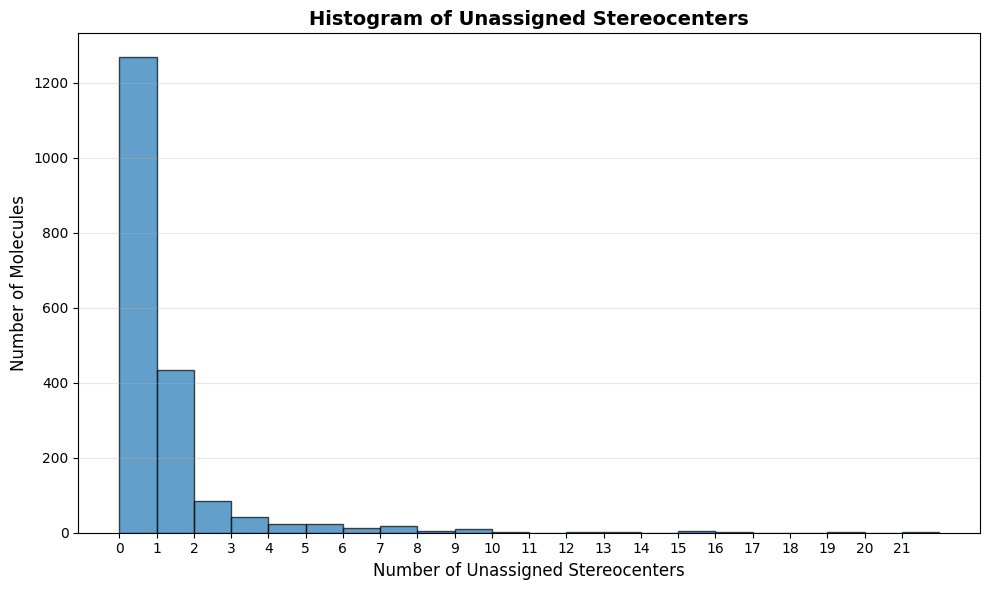

In [6]:
def analyze_unassigned_stereocenters(df):
    """
    Calculates the number of unassigned stereocenters for each molecule.
    Lists all molecules with at least one unassigned stereocenter and creates a histogram.
    
    Args:
        df (pd.DataFrame): DataFrame with parsed molecules including 'mol' column
    """
    if len(df) == 0:
        print("No molecules to analyze.")
        return
    
    unassigned_counts = []
    molecules_with_unassigned = []
    
    for idx, row in df.iterrows():
        mol = row['mol']
        if mol is None:
            continue
        
        # Find chiral centers including unassigned ones
        chiral_centers = Chem.FindMolChiralCenters(mol, includeUnassigned=True)
        
        # Count unassigned stereocenters (chirality is '?')
        unassigned_count = sum(1 for _, chirality in chiral_centers if chirality == '?')
        unassigned_counts.append(unassigned_count)
        
        if unassigned_count > 0:
            name = row.get('name', f'Molecule {idx}')
            num = row.get('num', '')
            smiles = row.get('smiles', 'N/A')
            molecules_with_unassigned.append({
                'num': num,
                'name': name,
                'smiles': smiles,
                'unassigned_stereocenters': unassigned_count
            })
    
    # Add unassigned_stereocenters column to dataframe (but don't remove molecules)
    df['unassigned_stereocenters'] = unassigned_counts
    
    # Print statistics
    total_with_unassigned = sum(1 for count in unassigned_counts if count > 0)
    print(f"\nStereocenter analysis:")
    print(f"  Total molecules analyzed: {len(df)}")
    print(f"  Molecules with unassigned stereocenters: {total_with_unassigned}")
    print(f"  Total unassigned stereocenters: {sum(unassigned_counts)}")
    print(f"  Average unassigned stereocenters (for molecules with >0): {sum(unassigned_counts) / max(total_with_unassigned, 1):.2f}")
    
    # List molecules with unassigned stereocenters
    if len(molecules_with_unassigned) > 0:
        print(f"\nMolecules with at least one unassigned stereocenter:")
        print("=" * 80)
        for idx, mol_info in enumerate(molecules_with_unassigned, 1):
            print(f"\n{idx}. Number: {mol_info['num']}")
            print(f"   Name: {mol_info['name']}")
            print(f"   SMILES: {mol_info['smiles']}")
            print(f"   Unassigned stereocenters: {mol_info['unassigned_stereocenters']}")
        print("\n" + "=" * 80)
    else:
        print("\nNo molecules with unassigned stereocenters found.")
    
    # Create histogram
    if max(unassigned_counts) > 0:
        plt.figure(figsize=(10, 6))
        plt.hist(unassigned_counts, bins=range(max(unassigned_counts) + 2), 
                edgecolor='black', alpha=0.7)
        plt.xlabel('Number of Unassigned Stereocenters', fontsize=12)
        plt.ylabel('Number of Molecules', fontsize=12)
        plt.title('Histogram of Unassigned Stereocenters', fontsize=14, fontweight='bold')
        plt.xticks(range(max(unassigned_counts) + 1))
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo unassigned stereocenters found - skipping histogram.")

# Analyze unassigned stereocenters
print("Analyzing unassigned stereocenters...")
analyze_unassigned_stereocenters(deduplicated_df)


In [7]:
def assign_morgan_fingerprints(df):
    """
    Assigns Morgan fingerprints with different radius and length combinations.
    Creates 9 versions: radius 1, 2, 3 and length 512, 1024, 2048.
    
    Args:
        df (pd.DataFrame): DataFrame with parsed molecules including 'mol' column
        
    Returns:
        pd.DataFrame: New dataframe with original columns plus 9 Morgan fingerprint columns
    """
    if len(df) == 0:
        print("No molecules to process.")
        return pd.DataFrame()
    
    if 'mol' not in df.columns:
        print("Error: 'mol' column not found in dataframe.")
        return df
    
    # Create a copy of the dataframe
    new_df = df.copy()
    
    # Define radius and length combinations
    radii = [1, 2, 3]
    lengths = [512, 1024, 2048]
    
    print(f"\nGenerating Morgan fingerprints for {len(df)} molecules...")
    print(f"  Radius options: {radii}")
    print(f"  Length options: {lengths}")
    print(f"  Total combinations: {len(radii) * len(lengths)}")
    
    # Generate fingerprints for each combination
    for radius in radii:
        for length in lengths:
            column_name = f'morgan_r{radius}_l{length}'
            fingerprints = []
            # Create generator once per combination (can be reused for all molecules)
            fpgen = rdFingerprintGenerator.GetMorganGenerator(radius, length)
            
            for idx, row in df.iterrows():
                mol = row['mol']
                if mol is None:
                    fingerprints.append(None)
                else:
                    try:
                        # Generate Morgan fingerprint using rdFingerprintGenerator
                        fp = fpgen.GetFingerprint(mol)
                        # Convert to list for storage in dataframe
                        fingerprints.append(list(fp))
                    except Exception as e:
                        print(f"Warning: Failed to generate fingerprint for molecule {idx}: {e}")
                        fingerprints.append(None)
            
            new_df[column_name] = fingerprints
            print(f"  Generated: {column_name}")
    
    print(f"\nMorgan fingerprint assignment complete!")
    print(f"  New dataframe shape: {new_df.shape}")
    print(f"  New columns added: {len(radii) * len(lengths)}")
    
    return new_df

# Assign fingerprints
print("Assigning Morgan fingerprints...")
fingerprint_df = assign_morgan_fingerprints(deduplicated_df)

print(f"\nFingerprint dataframe shape: {fingerprint_df.shape}")
print(f"Fingerprint dataframe columns: {fingerprint_df.columns.tolist()}")
print(f"\nFirst few rows (showing non-fingerprint columns):")
# Display without the mol and fingerprint columns
display_cols = [col for col in fingerprint_df.columns 
               if col != 'mol' and not col.startswith('morgan_')]
fingerprint_df[display_cols].head()


Assigning Morgan fingerprints...

Generating Morgan fingerprints for 1935 molecules...
  Radius options: [1, 2, 3]
  Length options: [512, 1024, 2048]
  Total combinations: 9
  Generated: morgan_r1_l512
  Generated: morgan_r1_l1024
  Generated: morgan_r1_l2048
  Generated: morgan_r2_l512
  Generated: morgan_r2_l1024
  Generated: morgan_r2_l2048
  Generated: morgan_r3_l512
  Generated: morgan_r3_l1024
  Generated: morgan_r3_l2048

Morgan fingerprint assignment complete!
  New dataframe shape: (1935, 18)
  New columns added: 9

Fingerprint dataframe shape: (1935, 18)
Fingerprint dataframe columns: ['num', 'name', 'p_np', 'smiles', 'mol', 'inchi', 'inchikey', 'id', 'unassigned_stereocenters', 'morgan_r1_l512', 'morgan_r1_l1024', 'morgan_r1_l2048', 'morgan_r2_l512', 'morgan_r2_l1024', 'morgan_r2_l2048', 'morgan_r3_l512', 'morgan_r3_l1024', 'morgan_r3_l2048']

First few rows (showing non-fingerprint columns):


num                 name  p_np  \
0  1302       hydromorphinol     1   
1   581             diazepam     1   
2  1245      fludrocortisone     1   
3  1653         valdipromide     1   
4   260  guanethidinesulfate     0   

                                              smiles  \
0  [C@@]125C3=C4C[C@H]([C@@]1(CC[C@@H]([C@@H]2OC3...   
1                CN1C(=O)CN=C(c2ccccc2)c3cc(Cl)ccc13   
2  [C@H]23[C@@]([C@@]1(C(=CC(=O)CC1)CC2)C)([C@H](...   
3                             C(C(C(N)=O)(CCC)CCC)CC   
4                                NC(N)=NCCN1CCCCCCC1   

                                               inchi  \
0  InChI=1S/C17H21NO4/c1-18-7-6-16-13-9-2-3-10(19...   
1  InChI=1S/C16H13ClN2O/c1-19-14-8-7-12(17)9-13(1...   
2  InChI=1S/C21H29FO5/c1-18-7-5-13(24)9-12(18)3-4...   
3  InChI=1S/C11H23NO/c1-4-7-11(8-5-2,9-6-3)10(12)...   
4  InChI=1S/C10H22N4/c11-10(12)13-6-9-14-7-4-2-1-...   

                      inchikey              id  unassigned_stereocenters  
0  AABLHGPVOULICI-BRJGLHKUSA-N  AABLHGPVOULICI                         0  
1  AAOVKJBEBIDNHE-UHFFFAOYSA-N  AAOVKJBEBIDNHE                         0  
2  AAXVEMMRQDVLJB-BULBTXNYSA-N  AAXVEMMRQDVLJB                         0  
3  ACBLZFZDCOGNHD-UHFFFAOYSA-N  ACBLZFZDCOGNHD                         0  
4  ACGDKVXYNVEAGU-UHFFFAOYSA-N  ACGDKVXYNVEAGU                         0

## Step 7: Butina Split (Train/Test)


In [8]:
def butina_split(df, fingerprint_col='morgan_r2_l1024', train_ratio=0.8, cutoff=0.7):
    """
    Creates a Butina split of the dataset into train (~80%) and test (~20%) sets.
    Uses Butina clustering to ensure similar molecules are grouped together.
    
    Args:
        df (pd.DataFrame): DataFrame with molecules and fingerprint columns
        fingerprint_col (str): Name of the fingerprint column to use (default: 'morgan_r2_l1024')
        train_ratio (float): Desired ratio for training set (default: 0.8)
        cutoff (float): Distance cutoff for Butina clustering (default: 0.7)
        
    Returns:
        tuple: (train_df, test_df) - Training and test dataframes
    """
    if len(df) == 0:
        print("No molecules to split.")
        return pd.DataFrame(), pd.DataFrame()
    
    if fingerprint_col not in df.columns:
        print(f"Error: Fingerprint column '{fingerprint_col}' not found.")
        print(f"Available fingerprint columns: {[col for col in df.columns if col.startswith('morgan_')]}")
        return pd.DataFrame(), pd.DataFrame()
    
    print(f"\nPerforming Butina split...")
    print(f"  Using fingerprint: {fingerprint_col}")
    print(f"  Target train ratio: {train_ratio:.1%}")
    print(f"  Distance cutoff: {cutoff}")
    
    # Extract fingerprints and convert to RDKit format
    fingerprints = []
    valid_indices = []
    
    for idx, row in df.iterrows():
        fp_list = row[fingerprint_col]
        if fp_list is not None and len(fp_list) > 0:
            # Convert list of 0s and 1s back to RDKit BitVect
            # Create a bit string from the list
            bit_string = ''.join(['1' if bit else '0' for bit in fp_list])
            fp = DataStructs.CreateFromBitString(bit_string)
            fingerprints.append(fp)
            valid_indices.append(idx)
    
    if len(fingerprints) == 0:
        print("Error: No valid fingerprints found.")
        return pd.DataFrame(), pd.DataFrame()
    
    print(f"  Valid molecules: {len(fingerprints)}")
    
    # Calculate distance matrix (Tanimoto distance = 1 - Tanimoto similarity)
    nfps = len(fingerprints)
    dists = []
    for i in range(1, nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fingerprints[i], fingerprints[:i])
        dists.extend([1 - x for x in sims])
    
    # Perform Butina clustering
    clusters = Butina.ClusterData(dists, nfps, cutoff, isDistData=True)
    print(f"  Number of clusters: {len(clusters)}")
    
    # Sort clusters by size (largest first)
    clusters_sorted = sorted(clusters, key=len, reverse=True)
    
    # Assign clusters to train or test to achieve target ratio
    train_indices = []
    test_indices = []
    total_assigned = 0
    
    for cluster in clusters_sorted:
        cluster_indices = [valid_indices[i] for i in cluster]
        current_ratio = len(train_indices) / max(total_assigned + len(cluster), 1)
        
        # Assign to train if we're below target ratio, otherwise to test
        if current_ratio < train_ratio:
            train_indices.extend(cluster_indices)
        else:
            test_indices.extend(cluster_indices)
        
        total_assigned += len(cluster)
    
    # Create train and test dataframes
    train_df = df.loc[train_indices].copy()
    test_df = df.loc[test_indices].copy()
    
    # Reset indices
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    
    actual_train_ratio = len(train_df) / len(df)
    print(f"\nButina split complete!")
    print(f"  Train set: {len(train_df)} molecules ({actual_train_ratio:.1%})")
    print(f"  Test set: {len(test_df)} molecules ({1-actual_train_ratio:.1%})")
    print(f"  Total: {len(train_df) + len(test_df)} molecules")
    
    return train_df, test_df

# Create Butina split
print("Creating Butina split...")
train_df, test_df = butina_split(fingerprint_df)

print(f"\nTrain dataframe shape: {train_df.shape}")
print(f"Test dataframe shape: {test_df.shape}")
print(f"\nTrain set columns: {train_df.columns.tolist()}")
print(f"\nFirst few train molecules:")
display_cols = [col for col in train_df.columns 
               if col != 'mol' and not col.startswith('morgan_')]
train_df[display_cols].head()


Creating Butina split...

Performing Butina split...
  Using fingerprint: morgan_r2_l1024
  Target train ratio: 80.0%
  Distance cutoff: 0.7
  Valid molecules: 1935
  Number of clusters: 345

Butina split complete!
  Train set: 1548 molecules (80.0%)
  Test set: 387 molecules (20.0%)
  Total: 1935 molecules

Train dataframe shape: (1548, 18)
Test dataframe shape: (387, 18)

Train set columns: ['num', 'name', 'p_np', 'smiles', 'mol', 'inchi', 'inchikey', 'id', 'unassigned_stereocenters', 'morgan_r1_l512', 'morgan_r1_l1024', 'morgan_r1_l2048', 'morgan_r2_l512', 'morgan_r2_l1024', 'morgan_r2_l2048', 'morgan_r3_l512', 'morgan_r3_l1024', 'morgan_r3_l2048']

First few train molecules:


num           name  p_np  \
0  1058   butaperazine     1   
1   714       moperone     1   
2  1099     citatepine     1   
3  1604  thiopropazate     1   
4  1326   ketobemidone     1   

                                              smiles  \
0  C1=C(C(CCC)=O)C=CC3=C1N(C2=C(C=CC=C2)S3)CCCN4C...   
1        Cc1ccc(cc1)C2(O)CCN(CCCC(=O)c3ccc(F)cc3)CC2   
2    C1=C(C#N)C=CC3=C1C4=C(C2=C(C=CC=C2)S3)CCN(CC4)C   
3  C1=C(Cl)C=CC3=C1N(C2=C(C=CC=C2)S3)CCCN4CCN(CCO...   
4                 C1=C(C=CC=C1C2(CCN(C)CC2)C(CC)=O)O   

                                               inchi  \
0  InChI=1S/C24H31N3OS/c1-3-7-22(28)19-10-11-24-2...   
1  InChI=1S/C22H26FNO2/c1-17-4-8-19(9-5-17)22(26)...   
2  InChI=1S/C20H18N2S/c1-22-10-8-15-16(9-11-22)18...   
3  InChI=1S/C23H28ClN3O2S/c1-18(28)29-16-15-26-13...   
4  InChI=1S/C15H21NO2/c1-3-14(18)15(7-9-16(2)10-8...   

                      inchikey              id  unassigned_stereocenters  
0  DVLBYTMYSMAKHP-UHFFFAOYSA-N  DVLBYTMYSMAKHP                         0  
1  AGAHNABIDCTLHW-UHFFFAOYSA-N  AGAHNABIDCTLHW                         0  
2  AGBTZJDOBMDLPR-UHFFFAOYSA-N  AGBTZJDOBMDLPR                         0  
3  AIUHRQHVWSUTGJ-UHFFFAOYSA-N  AIUHRQHVWSUTGJ                         0  
4  ALFGKMXHOUSVAD-UHFFFAOYSA-N  ALFGKMXHOUSVAD                         0

## Step 8: Train XGBoost Models (9 Cases) and Show Accuracies


Training XGBoost models...

Training XGBoost models for 9 fingerprint combinations...

  Training model for morgan_r1_l1024...
    Train samples: 1548, Test samples: 387


/Users/paweld/Projects/ai_in_chemistry_PW/.venv/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [16:39:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Test accuracy: 0.8553
    * New best model! (accuracy: 0.8553)

  Training model for morgan_r1_l2048...
    Train samples: 1548, Test samples: 387


/Users/paweld/Projects/ai_in_chemistry_PW/.venv/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [16:39:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Test accuracy: 0.8553

  Training model for morgan_r1_l512...
    Train samples: 1548, Test samples: 387


/Users/paweld/Projects/ai_in_chemistry_PW/.venv/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [16:39:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Test accuracy: 0.8553

  Training model for morgan_r2_l1024...
    Train samples: 1548, Test samples: 387


/Users/paweld/Projects/ai_in_chemistry_PW/.venv/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [16:39:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Test accuracy: 0.8553

  Training model for morgan_r2_l2048...
    Train samples: 1548, Test samples: 387


/Users/paweld/Projects/ai_in_chemistry_PW/.venv/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [16:39:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Test accuracy: 0.8553

  Training model for morgan_r2_l512...
    Train samples: 1548, Test samples: 387


/Users/paweld/Projects/ai_in_chemistry_PW/.venv/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [16:39:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Test accuracy: 0.8553

  Training model for morgan_r3_l1024...
    Train samples: 1548, Test samples: 387


/Users/paweld/Projects/ai_in_chemistry_PW/.venv/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [16:39:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Test accuracy: 0.8450

  Training model for morgan_r3_l2048...
    Train samples: 1548, Test samples: 387


/Users/paweld/Projects/ai_in_chemistry_PW/.venv/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [16:39:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Test accuracy: 0.8450

  Training model for morgan_r3_l512...
    Train samples: 1548, Test samples: 387


/Users/paweld/Projects/ai_in_chemistry_PW/.venv/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [16:39:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Test accuracy: 0.8450

XGBoost Training Results:
  morgan_r1_l1024: 0.8553
  morgan_r1_l2048: 0.8553
  morgan_r1_l512: 0.8553
  morgan_r2_l1024: 0.8553
  morgan_r2_l2048: 0.8553
  morgan_r2_l512: 0.8553
  morgan_r3_l1024: 0.8450
  morgan_r3_l2048: 0.8450
  morgan_r3_l512: 0.8450


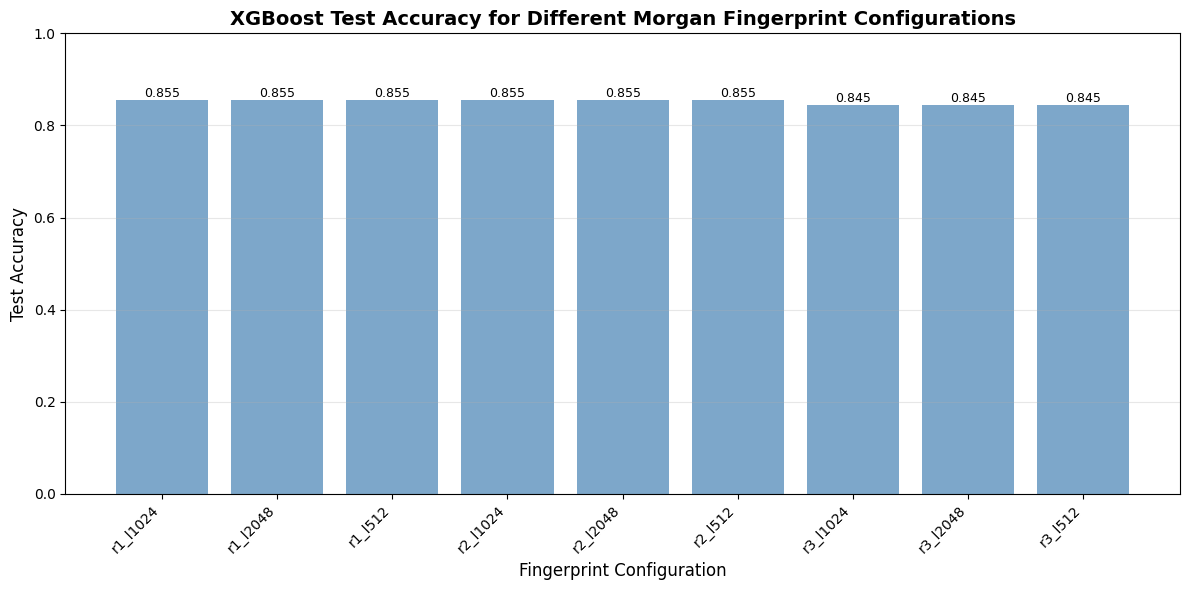


Best Model Summary:
  Fingerprint: morgan_r1_l1024
  Test Accuracy: 0.8553
  Model saved for further evaluation.

Final results dictionary:
{'morgan_r1_l1024': 0.8552971576227391, 'morgan_r1_l2048': 0.8552971576227391, 'morgan_r1_l512': 0.8552971576227391, 'morgan_r2_l1024': 0.8552971576227391, 'morgan_r2_l2048': 0.8552971576227391, 'morgan_r2_l512': 0.8552971576227391, 'morgan_r3_l1024': 0.8449612403100775, 'morgan_r3_l2048': 0.8449612403100775, 'morgan_r3_l512': 0.8449612403100775}

Best model available for further evaluation:
  Fingerprint: morgan_r1_l1024
  Accuracy: 0.8553
  Model object: XGBClassifier


In [9]:
def train_xgboost_models(train_df, test_df):
    """
    Trains XGBoost models using all 9 Morgan fingerprint combinations.
    Calculates accuracy on test set for each model and keeps the best model.
    
    Args:
        train_df (pd.DataFrame): Training dataframe with fingerprint columns
        test_df (pd.DataFrame): Test dataframe with fingerprint columns
        
    Returns:
        tuple: (results_dict, best_model_info) where:
            - results_dict: Dictionary with fingerprint names as keys and accuracies as values
            - best_model_info: Dictionary with 'model', 'fingerprint_col', 'accuracy', 
                             'X_train', 'X_test', 'y_train', 'y_test' for the best model
    """
    if len(train_df) == 0 or len(test_df) == 0:
        print("Error: Train or test dataframes are empty.")
        return {}, {}
    
    # Get all Morgan fingerprint columns
    fingerprint_cols = [col for col in train_df.columns if col.startswith('morgan_')]
    
    if len(fingerprint_cols) == 0:
        print("Error: No Morgan fingerprint columns found.")
        return {}, {}
    
    print(f"\nTraining XGBoost models for {len(fingerprint_cols)} fingerprint combinations...")
    
    # Extract target variable
    if 'p_np' not in train_df.columns or 'p_np' not in test_df.columns:
        print("Error: 'p_np' column not found in dataframes.")
        return {}, {}
    
    y_train = train_df['p_np'].values
    y_test = test_df['p_np'].values
    
    results = {}
    best_model = None
    best_accuracy = -1
    best_fp_col = None
    best_X_train = None
    best_X_test = None
    best_y_train = None
    best_y_test = None
    
    for fp_col in sorted(fingerprint_cols):
        print(f"\n  Training model for {fp_col}...")
        
        # Extract fingerprints and convert to numpy arrays
        X_train_list = []
        X_test_list = []
        train_indices = []
        test_indices = []
        
        # Process training data
        for idx, row in train_df.iterrows():
            fp_list = row[fp_col]
            if fp_list is not None and len(fp_list) > 0:
                X_train_list.append(np.array(fp_list, dtype=np.float32))
                train_indices.append(idx)
        
        # Process test data
        for idx, row in test_df.iterrows():
            fp_list = row[fp_col]
            if fp_list is not None and len(fp_list) > 0:
                X_test_list.append(np.array(fp_list, dtype=np.float32))
                test_indices.append(idx)
        
        if len(X_train_list) == 0 or len(X_test_list) == 0:
            print(f"    Warning: No valid fingerprints found for {fp_col}")
            results[fp_col] = 0.0
            continue
        
        # Convert to numpy arrays
        X_train = np.array(X_train_list)
        X_test = np.array(X_test_list)
        y_train_valid = y_train[train_indices]
        y_test_valid = y_test[test_indices]
        
        print(f"    Train samples: {len(X_train)}, Test samples: {len(X_test)}")
        
        # Train XGBoost classifier
        try:
            model = xgb.XGBClassifier(
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                random_state=42,
                eval_metric='logloss',
                use_label_encoder=False
            )
            
            model.fit(X_train, y_train_valid)
            
            # Predict on test set
            y_pred = model.predict(X_test)
            
            # Calculate accuracy
            accuracy = accuracy_score(y_test_valid, y_pred)
            results[fp_col] = accuracy
            
            print(f"    Test accuracy: {accuracy:.4f}")
            
            # Track best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model
                best_fp_col = fp_col
                best_X_train = X_train
                best_X_test = X_test
                best_y_train = y_train_valid
                best_y_test = y_test_valid
                print(f"    * New best model! (accuracy: {accuracy:.4f})")
            
        except Exception as e:
            print(f"    Error training model: {e}")
            results[fp_col] = 0.0
    
    # Print results dictionary
    print(f"\n" + "="*50)
    print("XGBoost Training Results:")
    print("="*50)
    for fp_col, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
        print(f"  {fp_col}: {acc:.4f}")
    
    # Create bar plot
    if len(results) > 0:
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Sort by accuracy for better visualization
        sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
        fp_names = [name.replace('morgan_', '') for name, _ in sorted_results]
        accuracies = [acc for _, acc in sorted_results]
        
        bars = ax.bar(range(len(fp_names)), accuracies, color='steelblue', alpha=0.7)
        ax.set_xlabel('Fingerprint Configuration', fontsize=12)
        ax.set_ylabel('Test Accuracy', fontsize=12)
        ax.set_title('XGBoost Test Accuracy for Different Morgan Fingerprint Configurations', 
                     fontsize=14, fontweight='bold')
        ax.set_xticks(range(len(fp_names)))
        ax.set_xticklabels(fp_names, rotation=45, ha='right')
        ax.set_ylim([0, 1])
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar, acc in zip(bars, accuracies):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{acc:.3f}',
                   ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()
    
    # Prepare best model info
    best_model_info = {}
    if best_model is not None:
        best_model_info = {
            'model': best_model,
            'fingerprint_col': best_fp_col,
            'accuracy': best_accuracy,
            'X_train': best_X_train,
            'X_test': best_X_test,
            'y_train': best_y_train,
            'y_test': best_y_test
        }
        print(f"\n" + "="*50)
        print(f"Best Model Summary:")
        print(f"  Fingerprint: {best_fp_col}")
        print(f"  Test Accuracy: {best_accuracy:.4f}")
        print(f"  Model saved for further evaluation.")
        print("="*50)
    else:
        print("\nWarning: No valid model was trained.")
    
    return results, best_model_info

# Train XGBoost models
print("Training XGBoost models...")
xgboost_results, best_model_info = train_xgboost_models(train_df, test_df)

print(f"\nFinal results dictionary:")
print(xgboost_results)

if best_model_info:
    print(f"\nBest model available for further evaluation:")
    print(f"  Fingerprint: {best_model_info['fingerprint_col']}")
    print(f"  Accuracy: {best_model_info['accuracy']:.4f}")
    print(f"  Model object: {type(best_model_info['model']).__name__}")


## Step 9: Plot Test Predictions (TP, TN, FP, FN)


Plotting test set predictions...

Test Set Prediction Analysis:
  True Positives (correctly predicted as 1): 286
  True Negatives (correctly predicted as 0): 45
  False Positives (predicted 1, actual 0): 38
  False Negatives (predicted 0, actual 1): 18
  Total test molecules: 387

Plotting 286 correctly predicted molecules (label=1)...


/Users/paweld/Projects/ai_in_chemistry_PW/.venv/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:343: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


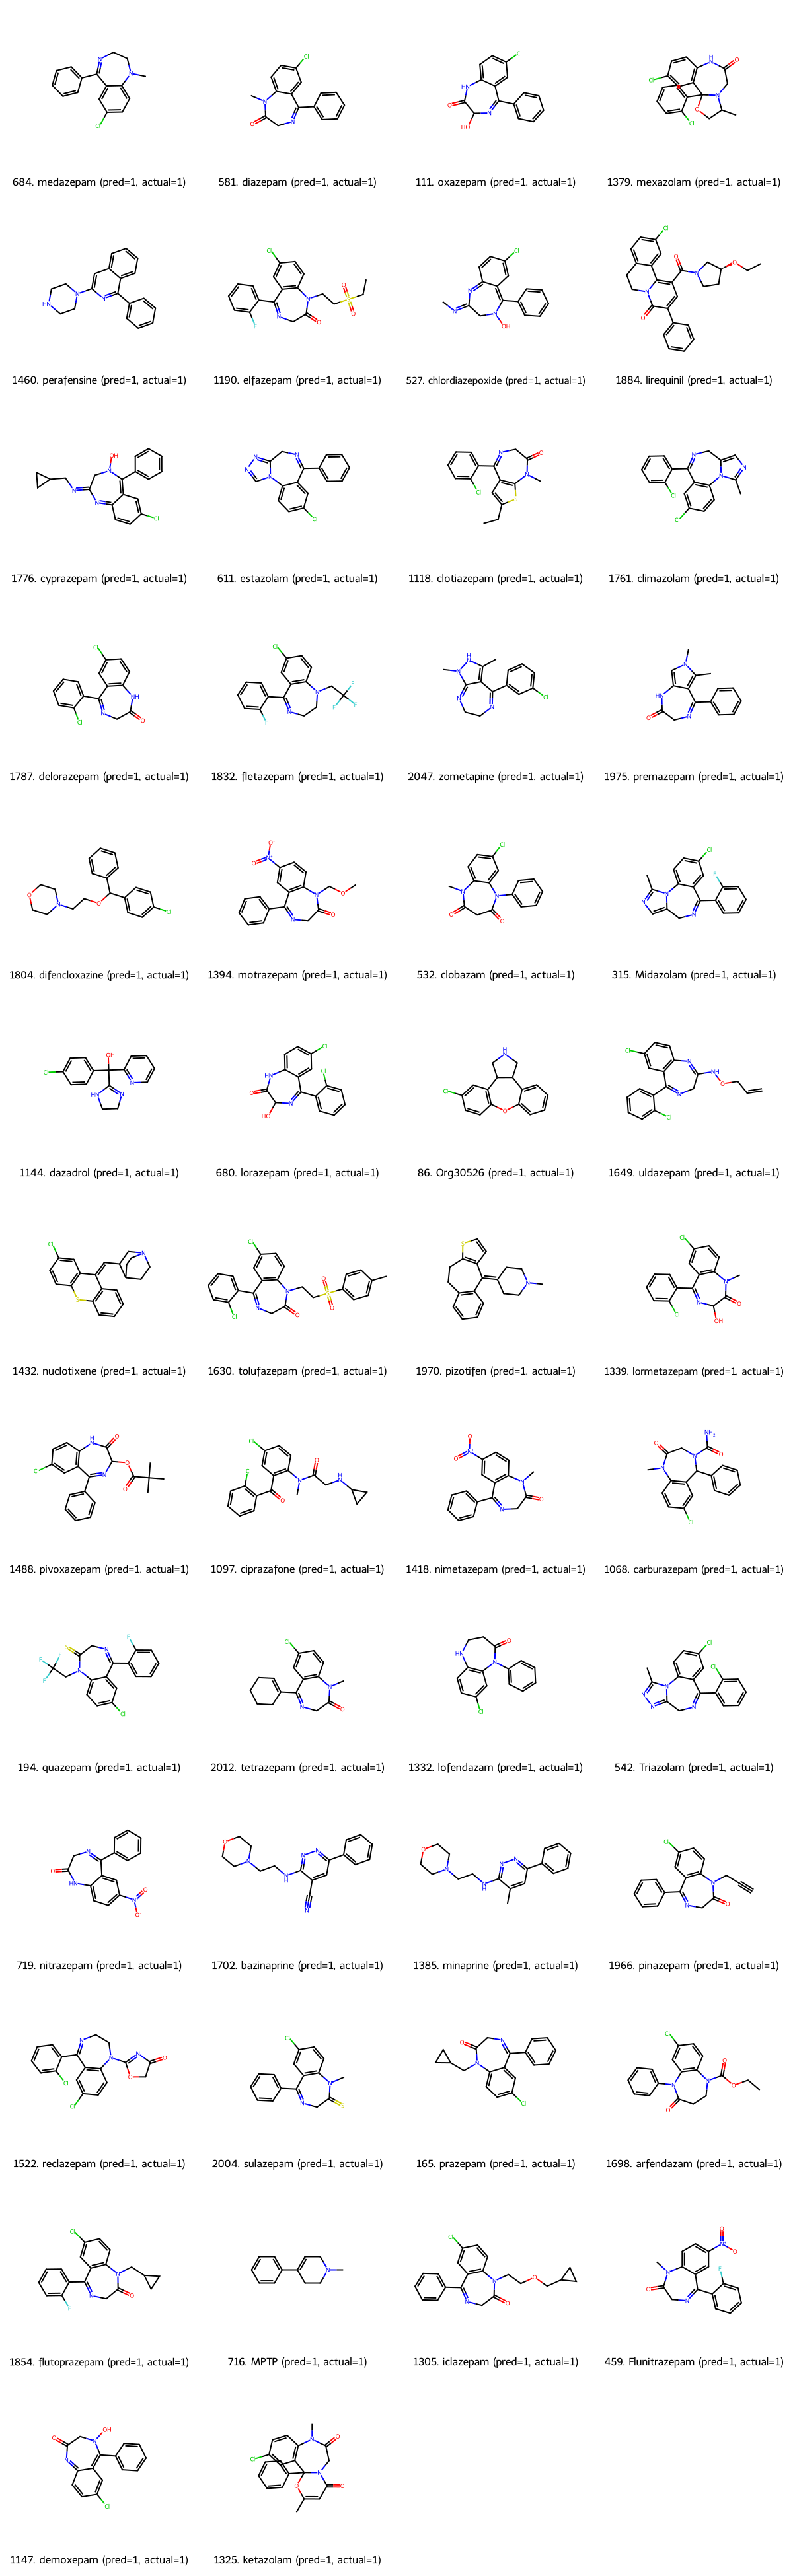


Plotting 45 correctly predicted molecules (label=0)...


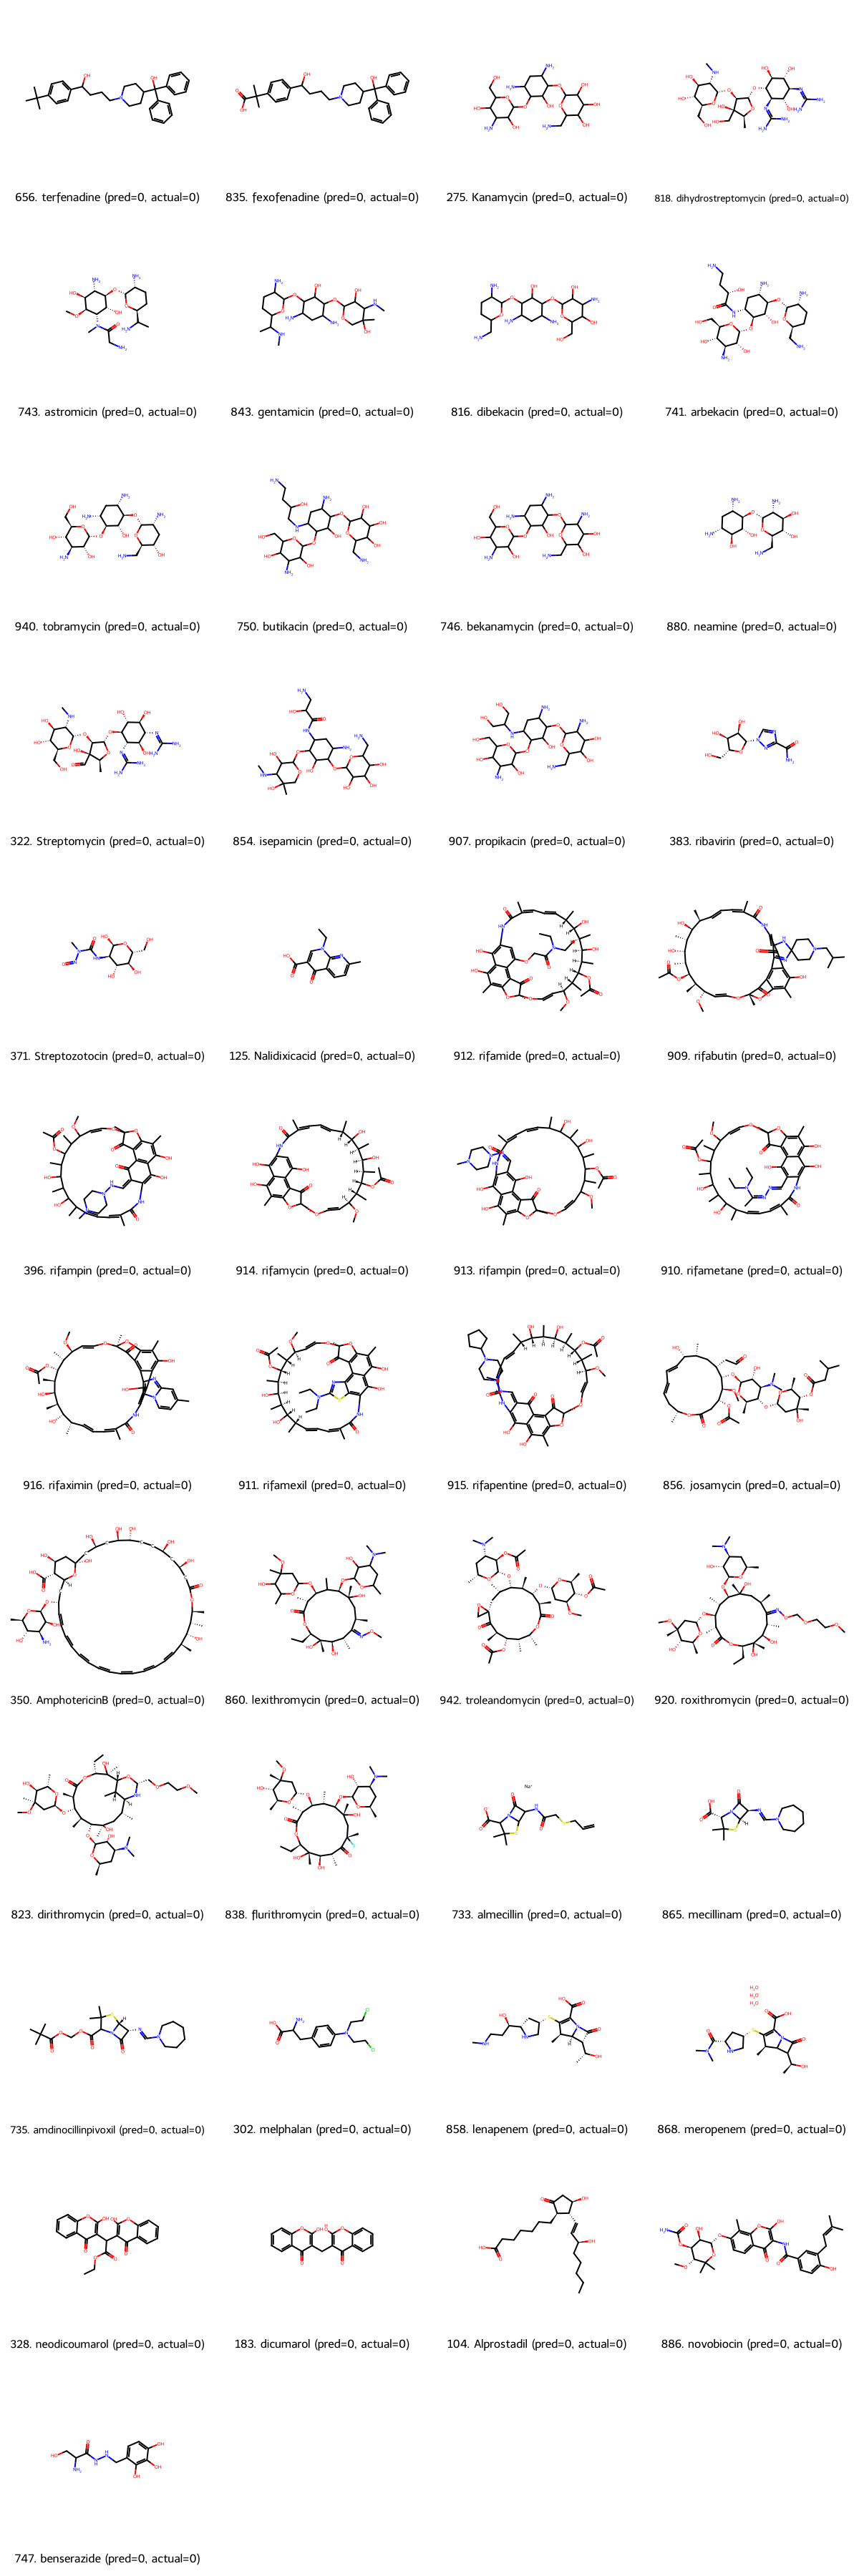


Plotting 38 incorrectly predicted molecules (predicted 1, actual 0)...


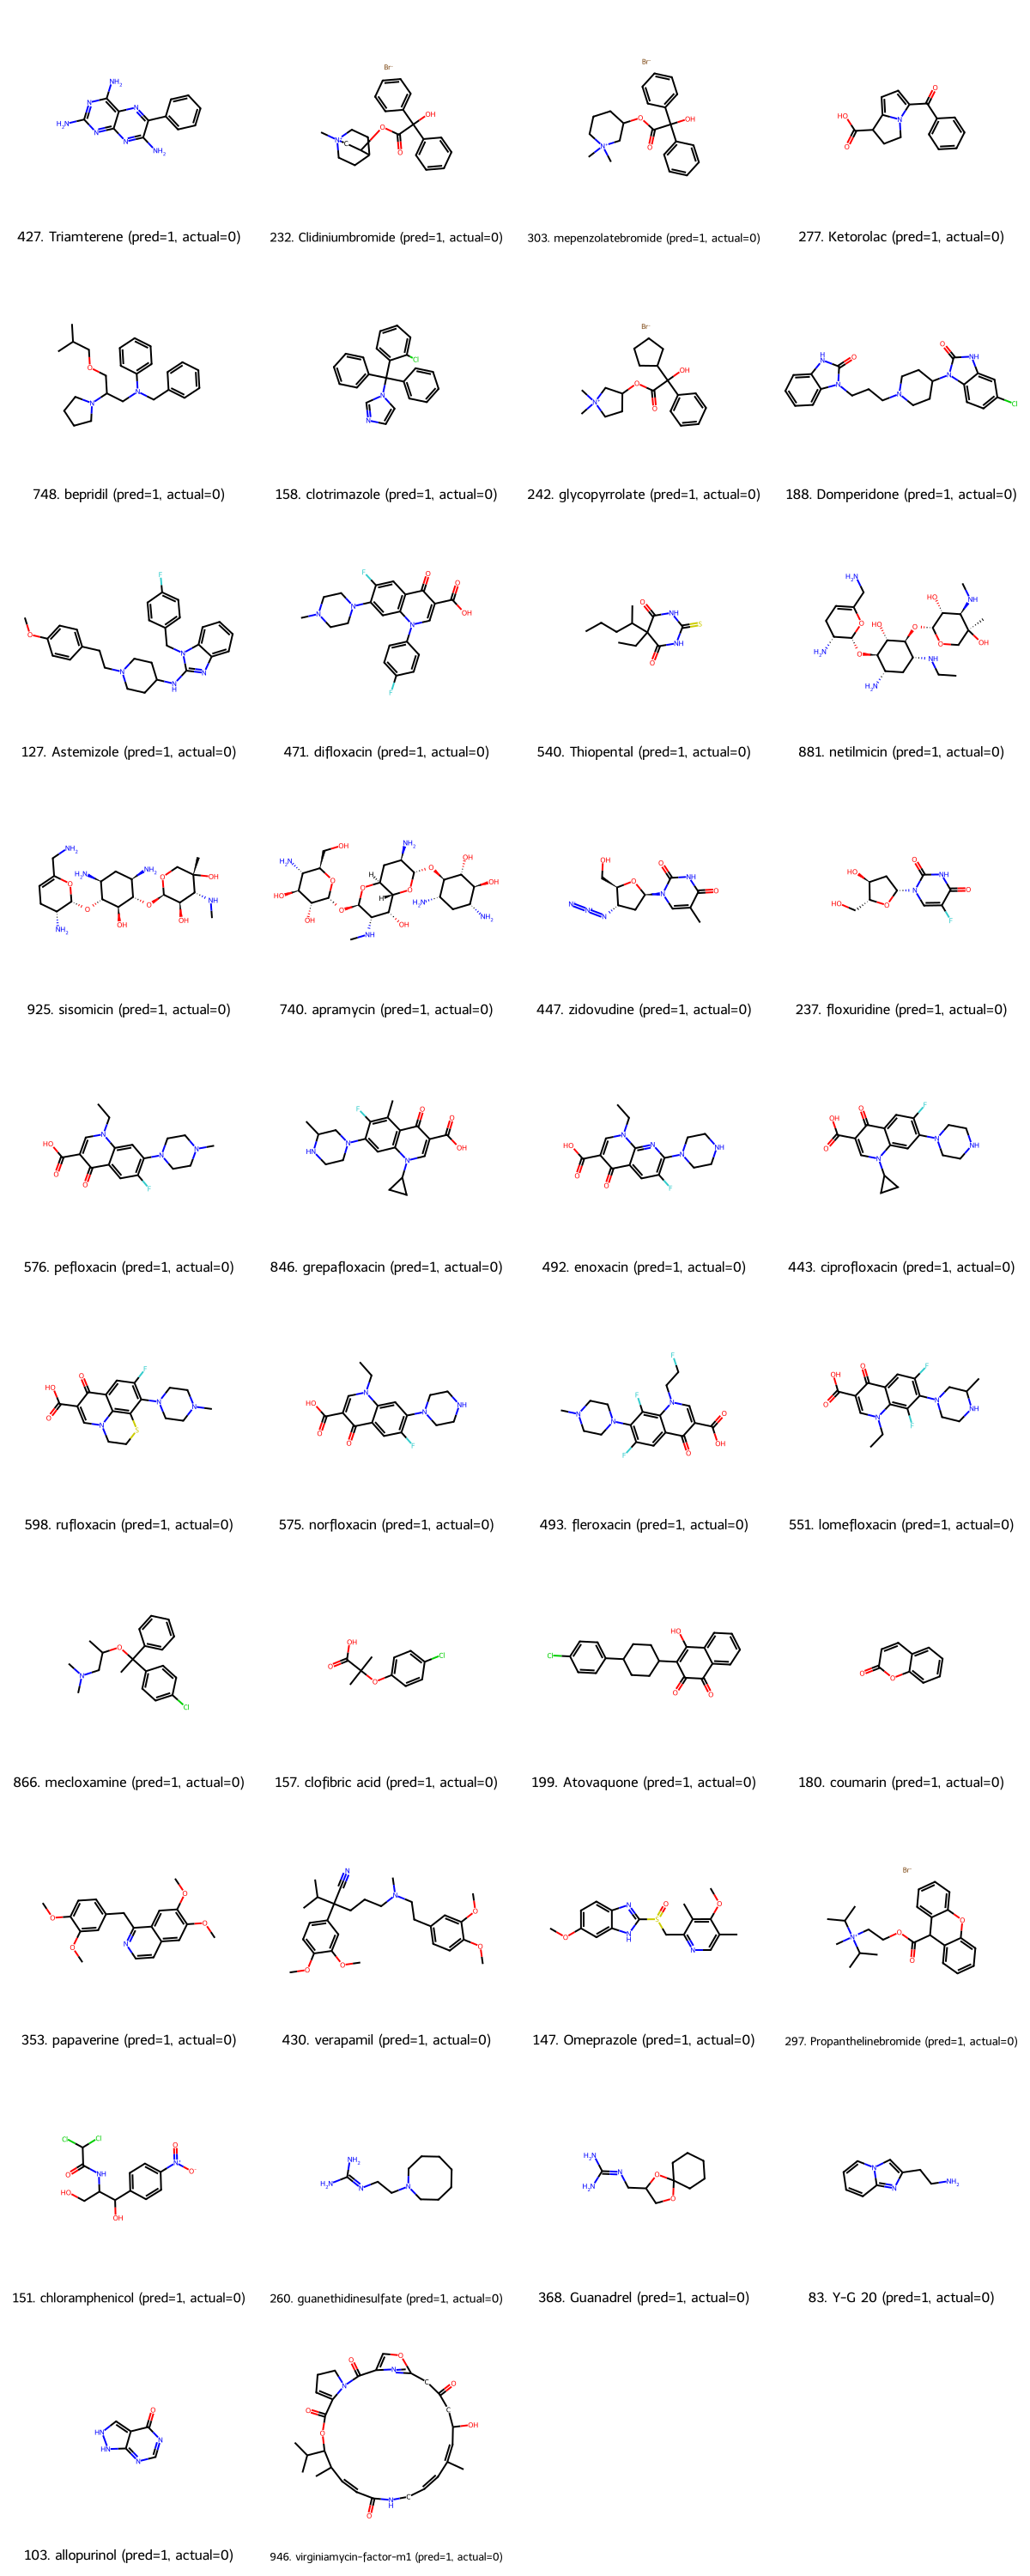


Plotting 18 incorrectly predicted molecules (predicted 0, actual 1)...


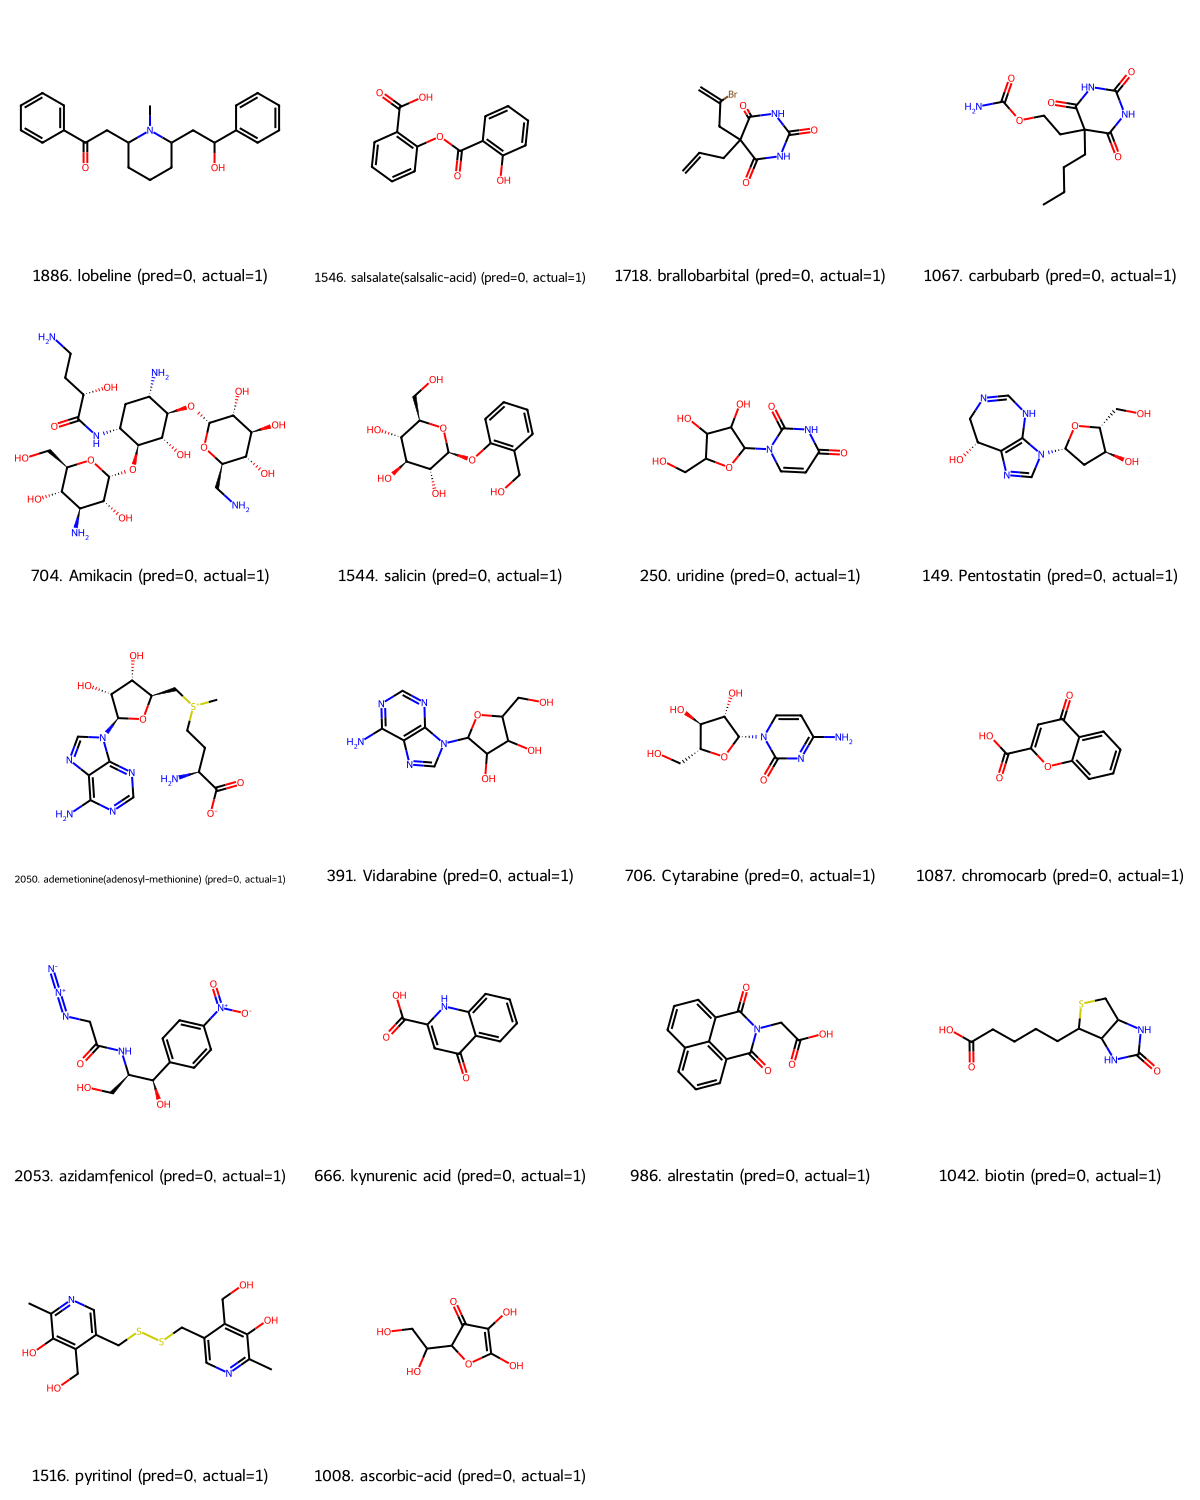

In [10]:
def plot_test_predictions(best_model_info, test_df, molsPerRow=4):
    """
    Plots test set molecules grouped by prediction correctness:
    - Correctly predicted as 1 (true positives)
    - Correctly predicted as 0 (true negatives)
    - Incorrectly predicted (false positives and false negatives)
    
    Args:
        best_model_info (dict): Dictionary containing the best model and related data
        test_df (pd.DataFrame): Test dataframe with molecules
        molsPerRow (int): Number of molecules per row in grid (default: 4)
    """
    if not best_model_info or 'model' not in best_model_info:
        print("Error: Best model information not available.")
        return
    
    model = best_model_info['model']
    fingerprint_col = best_model_info['fingerprint_col']
    y_test = best_model_info['y_test']
    X_test = best_model_info['X_test']
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Get corresponding molecules from test_df
    # Match the order used when creating X_test in train_xgboost_models
    test_indices = []
    for idx, row in test_df.iterrows():
        fp_list = row[fingerprint_col]
        if fp_list is not None and len(fp_list) > 0:
            test_indices.append(idx)
    
    # Ensure we have the same number of predictions as test indices
    if len(y_pred) != len(test_indices):
        print(f"Warning: Mismatch between predictions ({len(y_pred)}) and test indices ({len(test_indices)})")
        min_len = min(len(y_pred), len(test_indices))
        y_pred = y_pred[:min_len]
        y_test = y_test[:min_len]
        test_indices = test_indices[:min_len]
    
    # Categorize predictions
    true_positives = []  # Correctly predicted as 1
    true_negatives = []  # Correctly predicted as 0
    false_positives = []  # Predicted 1 but actual 0
    false_negatives = []  # Predicted 0 but actual 1
    
    tp_legends = []
    tn_legends = []
    fp_legends = []
    fn_legends = []
    
    for i, (pred, actual) in enumerate(zip(y_pred, y_test)):
        test_idx = test_indices[i]
        row = test_df.loc[test_idx]
        mol = row.get('mol')
        
        if mol is None:
            continue
        
        name = row.get('name', 'Unknown')
        num = row.get('num', '')
        legend = f"{num}. {name} (pred={pred}, actual={actual})" if num else f"{name} (pred={pred}, actual={actual})"
        
        if pred == 1 and actual == 1:
            true_positives.append(mol)
            tp_legends.append(legend)
        elif pred == 0 and actual == 0:
            true_negatives.append(mol)
            tn_legends.append(legend)
        elif pred == 1 and actual == 0:
            false_positives.append(mol)
            fp_legends.append(legend)
        elif pred == 0 and actual == 1:
            false_negatives.append(mol)
            fn_legends.append(legend)
    
    print(f"\n" + "="*50)
    print("Test Set Prediction Analysis:")
    print("="*50)
    print(f"  True Positives (correctly predicted as 1): {len(true_positives)}")
    print(f"  True Negatives (correctly predicted as 0): {len(true_negatives)}")
    print(f"  False Positives (predicted 1, actual 0): {len(false_positives)}")
    print(f"  False Negatives (predicted 0, actual 1): {len(false_negatives)}")
    print(f"  Total test molecules: {len(y_test)}")
    
    # Plot True Positives
    if len(true_positives) > 0:
        print(f"\nPlotting {len(true_positives)} correctly predicted molecules (label=1)...")
        img_tp = Draw.MolsToGridImage(
            true_positives,
            molsPerRow=molsPerRow,
            legends=tp_legends,
            subImgSize=(300, 300),
            returnPNG=False
        )
        display(img_tp)
    else:
        print("\nNo true positives to display.")
    
    # Plot True Negatives
    if len(true_negatives) > 0:
        print(f"\nPlotting {len(true_negatives)} correctly predicted molecules (label=0)...")
        img_tn = Draw.MolsToGridImage(
            true_negatives,
            molsPerRow=molsPerRow,
            legends=tn_legends,
            subImgSize=(300, 300),
            returnPNG=False
        )
        display(img_tn)
    else:
        print("\nNo true negatives to display.")
    
    # Plot False Positives (predicted 1, actual 0)
    if len(false_positives) > 0:
        print(f"\nPlotting {len(false_positives)} incorrectly predicted molecules (predicted 1, actual 0)...")
        img_fp = Draw.MolsToGridImage(
            false_positives,
            molsPerRow=molsPerRow,
            legends=fp_legends,
            subImgSize=(300, 300),
            returnPNG=False
        )
        display(img_fp)
    else:
        print("\nNo false positives to display.")
    
    # Plot False Negatives (predicted 0, actual 1)
    if len(false_negatives) > 0:
        print(f"\nPlotting {len(false_negatives)} incorrectly predicted molecules (predicted 0, actual 1)...")
        img_fn = Draw.MolsToGridImage(
            false_negatives,
            molsPerRow=molsPerRow,
            legends=fn_legends,
            subImgSize=(300, 300),
            returnPNG=False
        )
        display(img_fn)
    else:
        print("\nNo false negatives to display.")

# Plot test predictions
if best_model_info:
    print("Plotting test set predictions...")
    plot_test_predictions(best_model_info, test_df)


## Step 10: Test Model on Known Molecules


Testing model on known molecules...

Testing model on known molecules...
  Using fingerprint: morgan_r1_l1024
  Radius: 1, Length: 1024
  Number of passing_barrier molecules: 9
  Number of non_passing molecules: 5

Failed Predictions Only:

Found 5 molecules with incorrect predictions:

1. Glucose (passing_barrier)
   SMILES: C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O
   Expected label: 1 (p_np=1)
   Predicted label: 0 (p_np=0) ❌
   Probability class 0: 0.7041
   Probability class 1: 0.2959

2. Vitamin C (passing_barrier)
   SMILES: C([C@@H]1[C@H](C(=C(C1=O)O)O)O)O
   Expected label: 1 (p_np=1)
   Predicted label: 0 (p_np=0) ❌
   Probability class 0: 0.8761
   Probability class 1: 0.1239

3. Sodium ion (non_passing)
   SMILES: [Na+]
   Expected label: 0 (p_np=0)
   Predicted label: 1 (p_np=1) ❌
   Probability class 0: 0.0292
   Probability class 1: 0.9708

4. Potassium ion (non_passing)
   SMILES: [K+]
   Expected label: 0 (p_np=0)
   Predicted label: 1 (p_np=1) ❌
   Probability class 

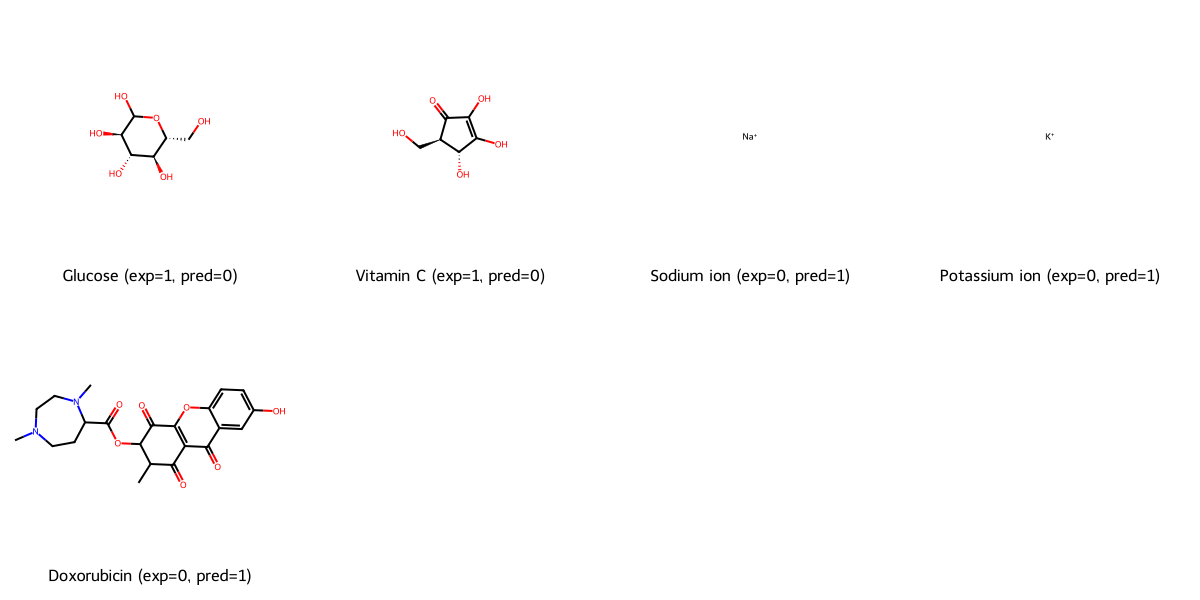

In [11]:
def test_on_known_molecules(best_model_info, passing_barrier=None, non_passing=None):
    """
    Tests the model on lists of known molecules that pass or don't pass the blood-brain barrier.
    
    Args:
        best_model_info (dict): Dictionary containing the best model and related data
        passing_barrier (list): List of dictionaries with 'name' and 'smiles' keys for molecules
                               that pass the barrier. If None, uses default list.
        non_passing (list): List of dictionaries with 'name' and 'smiles' keys for molecules
                           that don't pass the barrier. If None, uses default list.
    """
    if not best_model_info or 'model' not in best_model_info:
        print("Error: Best model information not available.")
        return
    
    # Default passing_barrier molecules list
    if passing_barrier is None:
        passing_barrier = [
            {'name': 'Water', 'smiles': 'O'},
            {'name': 'Glucose', 'smiles': 'C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O'},
            {'name': 'Oxygen', 'smiles': 'O=O'},
            {'name': 'Carbon dioxide', 'smiles': 'O=C=O'},
            {'name': 'Ethanol', 'smiles': 'CCO'},
            {'name': 'Nicotine', 'smiles': 'CN1CCC[C@H]1c2cccnc2'},
            {'name': 'Morphine', 'smiles': 'CN1CC[C@]23C4=C5C=CC(=C4O)C[C@@H]2[C@@H]1C[C@@H]5[C@H](C3)O'},
            {'name': 'Tryptophan', 'smiles': 'c1ccc2c(c1)c(c[nH]2)CC(C(=O)O)N'},
            {'name': 'Vitamin C', 'smiles': 'C([C@@H]1[C@H](C(=C(C1=O)O)O)O)O'}
        ]
    
    # Default non_passing molecules list
    if non_passing is None:
        non_passing = [
            {'name': 'Sodium ion', 'smiles': '[Na+]'},
            {'name': 'Potassium ion', 'smiles': '[K+]'},
            {'name': 'Doxorubicin', 'smiles': 'CC1C(C(=O)C2=C(C1=O)C(=O)c3cc(O)ccc3O2)OC(=O)C4CCN(CCN4C)C'},
            {'name': 'Glucose-6-phosphate', 'smiles': 'C([C@@H]1[C@H]([C@@H]([C@H](C(O1)OP(=O)(O)O)O)O)O)O'},
            {'name': 'ADP', 'smiles': 'NC1=NC=NC2=C1N=CN2[C@@H]3O[C@H](COP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]3O'}
        ]
    
    model = best_model_info['model']
    fingerprint_col = best_model_info['fingerprint_col']
    
    # Extract radius and length from fingerprint column name
    # Format: morgan_r{radius}_l{length}
    parts = fingerprint_col.replace('morgan_', '').split('_')
    radius = int(parts[0].replace('r', ''))
    length = int(parts[1].replace('l', ''))
    
    print(f"\n" + "="*50)
    print("Testing model on known molecules...")
    print(f"  Using fingerprint: {fingerprint_col}")
    print(f"  Radius: {radius}, Length: {length}")
    print(f"  Number of passing_barrier molecules: {len(passing_barrier)}")
    print(f"  Number of non_passing molecules: {len(non_passing)}")
    
    # Create Morgan generator once (can be reused for all molecules)
    fpgen = rdFingerprintGenerator.GetMorganGenerator(radius, length)
    
    # Process molecules from both lists
    molecules = []
    fingerprints = []
    names = []
    smiles_list = []
    categories = []  # Track which category each molecule belongs to
    
    # Process passing_barrier molecules
    for mol_info in passing_barrier:
        name = mol_info.get('name', 'Unknown')
        smiles = mol_info.get('smiles', '')
        
        if not smiles:
            print(f"  Warning: No SMILES provided for {name}, skipping...")
            continue
        
        try:
            # Parse SMILES
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                print(f"  Warning: Failed to parse SMILES for {name}: {smiles}")
                continue
            
            # Generate fingerprint using rdFingerprintGenerator
            fp = fpgen.GetFingerprint(mol)
            fp_array = np.array(list(fp), dtype=np.float32)
            
            molecules.append(mol)
            fingerprints.append(fp_array)
            names.append(name)
            smiles_list.append(smiles)
            categories.append('passing_barrier')
            
            # print(f"  Processed (passing_barrier): {name} ({smiles})")
            
        except Exception as e:
            print(f"  Error processing {name}: {e}")
            continue
    
    # Process non_passing molecules
    for mol_info in non_passing:
        name = mol_info.get('name', 'Unknown')
        smiles = mol_info.get('smiles', '')
        
        if not smiles:
            print(f"  Warning: No SMILES provided for {name}, skipping...")
            continue
        
        try:
            # Parse SMILES
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                print(f"  Warning: Failed to parse SMILES for {name}: {smiles}")
                continue
            
            # Generate fingerprint using rdFingerprintGenerator
            fp = fpgen.GetFingerprint(mol)
            fp_array = np.array(list(fp), dtype=np.float32)
            
            molecules.append(mol)
            fingerprints.append(fp_array)
            names.append(name)
            smiles_list.append(smiles)
            categories.append('non_passing')
            
            # print(f"  Processed (non_passing): {name} ({smiles})")
            
        except Exception as e:
            print(f"  Error processing {name}: {e}")
            continue
    
    if len(fingerprints) == 0:
        print("Error: No valid molecules to test.")
        return
    
    # Make predictions
    X_test = np.array(fingerprints)
    predictions = model.predict(X_test)
    prediction_proba = model.predict_proba(X_test)
    
    # Collect all results and identify failed predictions
    results = []
    passing_results = []
    non_passing_results = []
    failed_predictions = []  # Molecules with incorrect predictions
    
    for i, (name, smiles, mol, pred, proba, category) in enumerate(zip(names, smiles_list, molecules, predictions, prediction_proba, categories)):
        prob_class_0 = proba[0]
        prob_class_1 = proba[1]
        result = {
            'name': name,
            'smiles': smiles,
            'molecule': mol,
            'prediction': int(pred),
            'probability_class_0': prob_class_0,
            'probability_class_1': prob_class_1,
            'category': category
        }
        results.append(result)
        
        if category == 'passing_barrier':
            passing_results.append(result)
            # Failed: passing_barrier molecule predicted as 0 (should be 1)
            if pred == 0:
                failed_predictions.append(result)
        else:
            non_passing_results.append(result)
            # Failed: non_passing molecule predicted as 1 (should be 0)
            if pred == 1:
                failed_predictions.append(result)
    
    # Display only failed predictions
    print(f"\n" + "="*50)
    print("Failed Predictions Only:")
    print("="*50)
    
    if len(failed_predictions) == 0:
        print("\nNo failed predictions! All molecules were correctly predicted.")
    else:
        print(f"\nFound {len(failed_predictions)} molecules with incorrect predictions:")
        for i, result in enumerate(failed_predictions, 1):
            name = result['name']
            smiles = result['smiles']
            pred = result['prediction']
            prob_class_0 = result['probability_class_0']
            prob_class_1 = result['probability_class_1']
            category = result['category']
            expected = 1 if category == 'passing_barrier' else 0
            
            print(f"\n{i}. {name} ({category})")
            print(f"   SMILES: {smiles}")
            print(f"   Expected label: {expected} ({'p_np=1' if expected == 1 else 'p_np=0'})")
            print(f"   Predicted label: {pred} ({'p_np=1' if pred == 1 else 'p_np=0'}) ❌")
            print(f"   Probability class 0: {prob_class_0:.4f}")
            print(f"   Probability class 1: {prob_class_1:.4f}")
    
    # Summary statistics
    print(f"\n" + "="*50)
    print("Summary Statistics:")
    print("="*50)
    passing_pred_1 = sum(1 for r in passing_results if r['prediction'] == 1)
    passing_pred_0 = sum(1 for r in passing_results if r['prediction'] == 0)
    non_passing_pred_1 = sum(1 for r in non_passing_results if r['prediction'] == 1)
    non_passing_pred_0 = sum(1 for r in non_passing_results if r['prediction'] == 0)
    
    print(f"\nPassing Barrier Molecules:")
    print(f"  Total: {len(passing_results)}")
    print(f"  Predicted as p_np=1 (passing): {passing_pred_1}")
    print(f"  Predicted as p_np=0 (not passing): {passing_pred_0}")
    
    print(f"\nNon-Passing Molecules:")
    print(f"  Total: {len(non_passing_results)}")
    print(f"  Predicted as p_np=1 (passing): {non_passing_pred_1}")
    print(f"  Predicted as p_np=0 (not passing): {non_passing_pred_0}")
    
    # Draw only molecules with failed predictions
    if len(failed_predictions) > 0:
        print(f"\nDrawing {len(failed_predictions)} molecules with failed predictions...")
        failed_mols = [r['molecule'] for r in failed_predictions]
        failed_preds = [r['prediction'] for r in failed_predictions]
        failed_names = [r['name'] for r in failed_predictions]
        failed_categories = [r['category'] for r in failed_predictions]
        expected_labels = [1 if cat == 'passing_barrier' else 0 for cat in failed_categories]
        
        legends = [f"{name} (exp={exp}, pred={pred})" for name, exp, pred in zip(failed_names, expected_labels, failed_preds)]
        
        img = Draw.MolsToGridImage(
            failed_mols,
            molsPerRow=min(4, len(failed_mols)),
            legends=legends,
            subImgSize=(300, 300),
            returnPNG=False
        )
        display(img)
    else:
        print("\nNo molecules to draw (all predictions were correct).")
    
    return results

# Test on known molecules
if best_model_info:
    print("Testing model on known molecules...")
    test_results = test_on_known_molecules(best_model_info)
